In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from IIRSimUtils import *
from FrequencyResponse import *
from FPGATestIO import *
from scipy.special import eval_chebyu

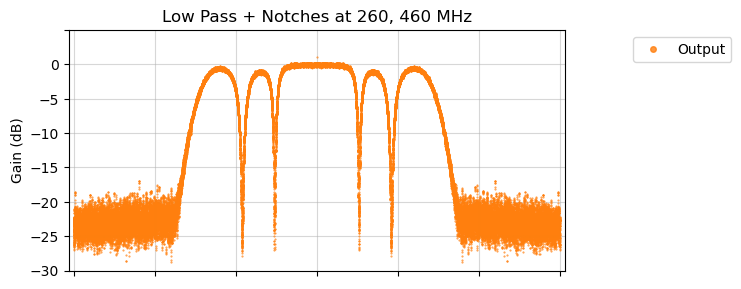

In [6]:
DEBUG=False
TRIALS = 7
NOTCH = 260
Q_FACTOR = 5
verilog_nominal_latency = 18*8 

# for NOTCH in range(250,620,5):
#     for Q_FACTOR in range(1,8,2):
if True:
    if True:    
        b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)
        
        with open("005_files/outputs/verilog/trigger_chain_output_gauss_1000_trial_%s_notch_%s_MHz_%s.txt"%(TRIALS-1, NOTCH, Q_FACTOR), "r") as in_file:
            data = []
            for line in in_file:
                data.append(convert_from_fixed_point(int(int(line)), 12, 0))
            verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
            clipped_length = int(len(verilog_data)/8)*8
        gauss_samps_array = np.zeros((TRIALS, clipped_length))
        output_samps_array = np.zeros((TRIALS, clipped_length))
        python_zero_after_samps_array = np.zeros((TRIALS, clipped_length))
        
        for trial_idx in range(TRIALS):
            verilog_data = []
            with open("005_files/outputs/verilog/trigger_chain_output_gauss_1000_trial_%s_notch_%s_MHz_%s.txt"%(trial_idx, NOTCH, Q_FACTOR), "r") as in_file:
                data = []
                for line in in_file:
                    data.append(convert_from_fixed_point(int(int(line)), 12, 0))
                verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
            gauss_run = import_data("001_files/inputs/gauss_input_1000_sigma_hanning_clipped_%s.dat"%trial_idx)
            gauss_original_samps = gauss_run.copy()
            gauss_delayed_samps = lfilter([0,1,0], [1], np.array(gauss_run.copy(), dtype=float))
            gauss_samps = gauss_run[:clipped_length].copy()
            clocks = range(len(gauss_samps))
            clocks = range(np.min([len(gauss_samps),len(verilog_data)]))
            gauss_samps_array[trial_idx] = gauss_samps[:len(clocks)]
            output_samps_array[trial_idx] = verilog_data[:len(clocks)]
            
        frequency_response_manual_v2(clocks, gauss_samps_array, output_samps_array, smooth=7, savename="005_files/plots/triggerChain_1000_gauss_frequnecy_response_notch_%sQ_%sMHz.png"%(Q_FACTOR, NOTCH), lfilter_coeffs=None, 
                                     SAMPLE_FREQ=3000, title="Low Pass + Notches at 260, 460 MHz", yscale = (-30,5))#"Notch at %s MHz, Q of %s"%(NOTCH, Q_FACTOR), diffscale=4.3)

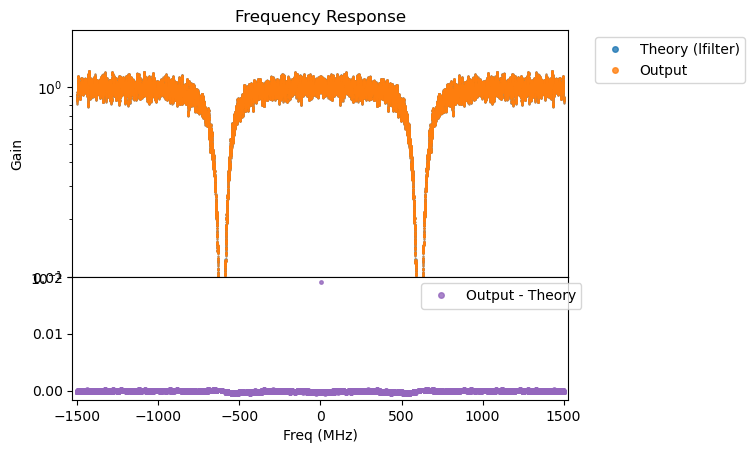

In [5]:
frequency_response_manual(clocks, gauss_samps_array, output_samps_array, smooth=43, savename=None, lfilter_coeffs=(b,a,), SAMPLE_FREQ=3000)

In [13]:
NOTCH = 450
Q_FACTOR = 5

In [14]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("003_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

In [15]:
coeffs_fixed_point_signed

array([ 17597,   5346,  -8816, -13892,  -7627,   3300,  17597,   5346,
        -8816, -13892,  -7627,   3300,   9854,  -2731,   9854,  -8152,
         7853,  -4448,   3081,  -2550,  -1139], dtype=int64)

In [18]:
a_fixed_point_signed

array([ 16384, -17598,  13554], dtype=int64)

# Plots From Network Analyzer

In [7]:
def csv_to_lists(filename, lines_to_skip=1, y_columns = 1):
    xs = []
    ys = []
    for y in range(y_columns):
        ys.append([])
    with open(filename, "r") as infile:
        counter = 0
        for line in infile:
            counter += 1
            if(counter<=lines_to_skip):
                continue
            line = line.split(",")
            for idx in range(len(line)):
                if(idx > y_columns):
                    break
                if(idx == 0):
                    xs.append(float(line[idx].strip()))
                else:
                    ys[idx-1].append(float(line[idx].strip()))
    xs = np.array(xs)
    for y in range(y_columns):
        ys[y] = np.array(ys[y])
    return xs, ys

In [8]:
xs_empty, ys_empty = csv_to_lists("003_files/NetworkAnalyzer/EMPTYTRACE.CSV", lines_to_skip=3)

In [9]:
xs_650_5, ys_650_5 = csv_to_lists("003_files/NetworkAnalyzer/NOTCHTRACE650_5_V2.CSV", lines_to_skip=3)

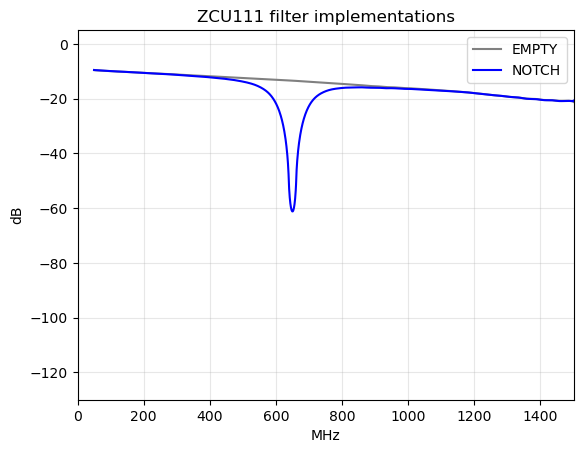

In [10]:
plt.title("ZCU111 filter implementations")
plt.plot(xs_empty/(10**6), ys_empty[0], label="EMPTY", color = "grey")
plt.plot(xs_650_5/(10**6), ys_650_5[0], label="NOTCH", color = "blue")
# plt.plot(xs_cl/(10**6), ys_cl[0], label="Custom Filter Lower Power CHAN0", color = "teal")
# plt.plot(xs_clwr/(10**6), ys_clwr[0], label="Custom Filter Words Reversed CHAN0", color = "orange")
# plt.plot(xs_ip/(10**6), ys_ip[0], label="IP Filter CHAN1", color = "green")
# plt.plot(theory_frqs, theory_resps, linestyle=":", color="r", label = "Filter Design")
plt.xlabel("MHz")
plt.ylabel("dB")
plt.xlim(0,1500)
plt.ylim(-130,5)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

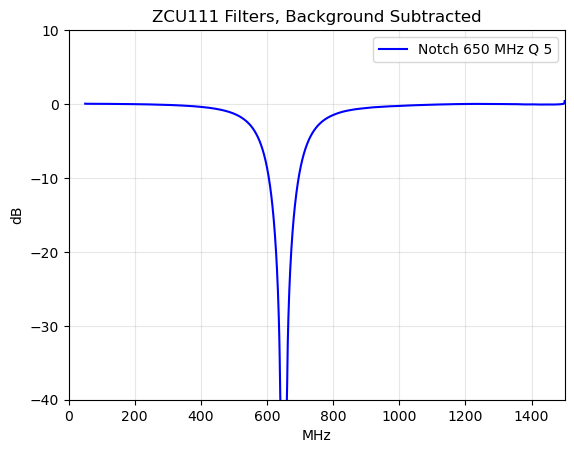

In [12]:
# plt.plot(xs, ys[0], label="16b-12b-16b")
plt.title("ZCU111 Filters, Background Subtracted")
plt.plot(xs_empty/(10**6), np.subtract(ys_650_5[0],ys_empty[0]), label="Notch 650 MHz Q 5", color = "blue")
# plt.plot(xs_cl/(10**6), np.subtract(ys_cl[0],ys[0]), label="Custom Filter Lower Power CHAN0", color = "teal")
# plt.plot(xs_ip/(10**6), np.subtract(ys_ip[0],ys[0]), label="IP Filter, CHAN1 (delta from CHAN0)", color = "green")
# plt.plot(theory_frqs, theory_resps, linestyle="--", color="r", label = "Filter Design")
plt.xlabel("MHz")
plt.ylabel("dB")
plt.xlim(0,1500)
plt.ylim(-40,10)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("004_files/NetworkAnalyzerNotch.png")
plt.show()